In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import QuantileTransformer
scaler = QuantileTransformer(output_distribution='uniform')
DATASET_DIRECTORY = '/kaggle/input/unb-cic-iot-dataset/wataiData/csv/CICIoT2023/'

In [2]:
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()
training_sets = df_sets[:int(len(df_sets)*.67)]
test_sets = df_sets[int(len(df_sets)*.67):]

In [3]:
X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
    'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
    'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
    'ece_flag_number', 'cwr_flag_number', 'ack_count',
    'syn_count', 'fin_count', 'urg_count', 'rst_count', 
    'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
    'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
    'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
    'Radius', 'Covariance', 'Variance', 'Weight', 
]
y_column = 'label'

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import L2

def build_CNN_model(input_shape):
  l2_reg = L2(0.001)  # Create an L2 instance with a fixed penalty (0.001)

  model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=input_shape, kernel_regularizer=l2_reg),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu', kernel_regularizer=l2_reg),
    MaxPooling1D(2),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2_reg),
    Dropout(0.5),
    Dense(34, activation='softmax')  # Output layer with softmax activation for multiclass
  ])
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model


2024-03-26 14:56:06.174377: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 14:56:06.174479: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 14:56:06.346165: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
DL_models = [
        build_CNN_model(input_shape=(len(X_columns),1))
            ]
DL_names = [
        "CNN",
]

In [6]:
dict_7classes = {}
dict_7classes['DDoS-RSTFINFlood'] = 'DDoS'
dict_7classes['DDoS-PSHACK_Flood'] = 'DDoS'
dict_7classes['DDoS-SYN_Flood'] = 'DDoS'
dict_7classes['DDoS-UDP_Flood'] = 'DDoS'
dict_7classes['DDoS-TCP_Flood'] = 'DDoS'
dict_7classes['DDoS-ICMP_Flood'] = 'DDoS'
dict_7classes['DDoS-SynonymousIP_Flood'] = 'DDoS'
dict_7classes['DDoS-ACK_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-UDP_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-ICMP_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-SlowLoris'] = 'DDoS'
dict_7classes['DDoS-HTTP_Flood'] = 'DDoS'

dict_7classes['DoS-UDP_Flood'] = 'DoS'
dict_7classes['DoS-SYN_Flood'] = 'DoS'
dict_7classes['DoS-TCP_Flood'] = 'DoS'
dict_7classes['DoS-HTTP_Flood'] = 'DoS'


dict_7classes['Mirai-greeth_flood'] = 'Mirai'
dict_7classes['Mirai-greip_flood'] = 'Mirai'
dict_7classes['Mirai-udpplain'] = 'Mirai'

dict_7classes['Recon-PingSweep'] = 'Recon'
dict_7classes['Recon-OSScan'] = 'Recon'
dict_7classes['Recon-PortScan'] = 'Recon'
dict_7classes['VulnerabilityScan'] = 'Recon'
dict_7classes['Recon-HostDiscovery'] = 'Recon'

dict_7classes['DNS_Spoofing'] = 'Spoofing'
dict_7classes['MITM-ArpSpoofing'] = 'Spoofing'

dict_7classes['BenignTraffic'] = 'Benign'

dict_7classes['BrowserHijacking'] = 'Web'
dict_7classes['Backdoor_Malware'] = 'Web'
dict_7classes['XSS'] = 'Web'
dict_7classes['Uploading_Attack'] = 'Web'
dict_7classes['SqlInjection'] = 'Web'
dict_7classes['CommandInjection'] = 'Web'


dict_7classes['DictionaryBruteForce'] = 'BruteForce'

In [7]:
for train_set in tqdm(training_sets):
        correlation_matrices=[]
        d = pd.read_csv(DATASET_DIRECTORY + train_set)
        d[X_columns] = scaler.fit_transform(d[X_columns])
        new_y = [dict_7classes[k] for k in d[y_column]]
        d[y_column] = new_y
        from sklearn.preprocessing import LabelEncoder

        label_encoder = LabelEncoder()
        d[y_column] = label_encoder.fit_transform(d[y_column].values)
        X_train = d[X_columns].values
        y_train = d[y_column].values
        for model in (DL_models):
            model.fit(X_train, y_train, epochs=3, batch_size=40, validation_split=0.3)
            correlation_matrices.append(d[X_columns].corrwith(d[y_column]))
        del d

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 1/3
  80/4177 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6074 - loss: 2.2048

I0000 00:00:1711464987.263917      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711464987.280890      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4177/4177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8980 - loss: 0.4621

W0000 00:00:1711464995.967304      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4177/4177 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.8980 - loss: 0.4621 - val_accuracy: 0.9800 - val_loss: 0.1221
Epoch 2/3
4177/4177 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9785 - loss: 0.1273 - val_accuracy: 0.9831 - val_loss: 0.1008
Epoch 3/3
4177/4177 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9811 - loss: 0.1044 - val_accuracy: 0.9812 - val_loss: 0.0951


  1%|          | 1/113 [00:41<1:17:28, 41.50s/it]

Epoch 1/3
  81/3830 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9808 - loss: 0.1043

W0000 00:00:1711465025.827532      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3830/3830 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9822 - loss: 0.0954 - val_accuracy: 0.9833 - val_loss: 0.0851
Epoch 2/3
3830/3830 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9829 - loss: 0.0877 - val_accuracy: 0.9831 - val_loss: 0.0794
Epoch 3/3
3830/3830 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9829 - loss: 0.0835 - val_accuracy: 0.9853 - val_loss: 0.0753


  2%|▏         | 2/113 [01:19<1:13:06, 39.51s/it]

Epoch 1/3
4817/4817 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9822 - loss: 0.0851 - val_accuracy: 0.9844 - val_loss: 0.0740
Epoch 2/3
  85/4817 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9840 - loss: 0.0803

W0000 00:00:1711465075.007424      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4817/4817 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9825 - loss: 0.0814 - val_accuracy: 0.9847 - val_loss: 0.0705
Epoch 3/3
4817/4817 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9827 - loss: 0.0793 - val_accuracy: 0.9855 - val_loss: 0.0680


  3%|▎         | 3/113 [02:00<1:13:52, 40.30s/it]

Epoch 1/3
4043/4043 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9831 - loss: 0.0773 - val_accuracy: 0.9860 - val_loss: 0.0666
Epoch 2/3
  85/4043 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9876 - loss: 0.0605

W0000 00:00:1711465115.972510      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4043/4043 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9841 - loss: 0.0742 - val_accuracy: 0.9862 - val_loss: 0.0641
Epoch 3/3
4043/4043 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9833 - loss: 0.0747 - val_accuracy: 0.9841 - val_loss: 0.0683


  4%|▎         | 4/113 [02:38<1:11:08, 39.16s/it]

Epoch 1/3
3982/3982 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9833 - loss: 0.0745 - val_accuracy: 0.9868 - val_loss: 0.0636
Epoch 2/3
3982/3982 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9835 - loss: 0.0727 - val_accuracy: 0.9862 - val_loss: 0.0629
Epoch 3/3
3982/3982 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9839 - loss: 0.0717 - val_accuracy: 0.9865 - val_loss: 0.0628


  4%|▍         | 5/113 [03:12<1:07:17, 37.39s/it]

Epoch 1/3
4201/4201 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9830 - loss: 0.0732 - val_accuracy: 0.9860 - val_loss: 0.0611
Epoch 2/3
4201/4201 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9839 - loss: 0.0710 - val_accuracy: 0.9853 - val_loss: 0.0625
Epoch 3/3
4201/4201 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9836 - loss: 0.0713 - val_accuracy: 0.9859 - val_loss: 0.0608


  5%|▌         | 6/113 [03:51<1:07:26, 37.82s/it]

Epoch 1/3
4092/4092 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9845 - loss: 0.0678 - val_accuracy: 0.9830 - val_loss: 0.0664
Epoch 2/3
4092/4092 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9847 - loss: 0.0672 - val_accuracy: 0.9858 - val_loss: 0.0626
Epoch 3/3
4092/4092 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9846 - loss: 0.0657 - val_accuracy: 0.9856 - val_loss: 0.0635


  6%|▌         | 7/113 [04:28<1:06:48, 37.82s/it]

Epoch 1/3
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9829 - loss: 0.0714 - val_accuracy: 0.9862 - val_loss: 0.0594
Epoch 2/3
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9839 - loss: 0.0678 - val_accuracy: 0.9854 - val_loss: 0.0638
Epoch 3/3
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9840 - loss: 0.0678 - val_accuracy: 0.9861 - val_loss: 0.0613


  7%|▋         | 8/113 [05:17<1:12:03, 41.18s/it]

Epoch 1/3
4311/4311 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9843 - loss: 0.0681

W0000 00:00:1711465311.801770      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4311/4311 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9843 - loss: 0.0681 - val_accuracy: 0.9863 - val_loss: 0.0608
Epoch 2/3
  86/4311 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9835 - loss: 0.0709

W0000 00:00:1711465315.153974      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4311/4311 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9846 - loss: 0.0657 - val_accuracy: 0.9853 - val_loss: 0.0605
Epoch 3/3
4311/4311 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9856 - loss: 0.0642 - val_accuracy: 0.9862 - val_loss: 0.0598


  8%|▊         | 9/113 [06:08<1:16:45, 44.28s/it]

Epoch 1/3
3984/3984 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9843 - loss: 0.0666 - val_accuracy: 0.9865 - val_loss: 0.0587
Epoch 2/3
3984/3984 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9843 - loss: 0.0660 - val_accuracy: 0.9869 - val_loss: 0.0580
Epoch 3/3
3984/3984 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9842 - loss: 0.0665 - val_accuracy: 0.9859 - val_loss: 0.0590


  9%|▉         | 10/113 [06:46<1:12:34, 42.27s/it]

Epoch 1/3
4400/4400 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9839 - loss: 0.0675 - val_accuracy: 0.9861 - val_loss: 0.0614
Epoch 2/3
4400/4400 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9835 - loss: 0.0682 - val_accuracy: 0.9863 - val_loss: 0.0608
Epoch 3/3
4400/4400 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9840 - loss: 0.0660 - val_accuracy: 0.9848 - val_loss: 0.0614


 10%|▉         | 11/113 [07:26<1:11:02, 41.79s/it]

Epoch 1/3
3884/3884 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9832 - loss: 0.0693

W0000 00:00:1711465440.134230      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3884/3884 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9832 - loss: 0.0692 - val_accuracy: 0.9856 - val_loss: 0.0587
Epoch 2/3
3884/3884 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9850 - loss: 0.0633 - val_accuracy: 0.9857 - val_loss: 0.0609
Epoch 3/3
3884/3884 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9836 - loss: 0.0661 - val_accuracy: 0.9861 - val_loss: 0.0600


 11%|█         | 12/113 [08:04<1:08:19, 40.59s/it]

Epoch 1/3
4174/4174 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9842 - loss: 0.0663 - val_accuracy: 0.9857 - val_loss: 0.0579
Epoch 2/3
4174/4174 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9844 - loss: 0.0646 - val_accuracy: 0.9860 - val_loss: 0.0586
Epoch 3/3
4174/4174 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9844 - loss: 0.0644 - val_accuracy: 0.9854 - val_loss: 0.0612


 12%|█▏        | 13/113 [08:43<1:06:53, 40.14s/it]

Epoch 1/3
4179/4179 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9844 - loss: 0.0655

W0000 00:00:1711465516.890775      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4179/4179 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9844 - loss: 0.0655 - val_accuracy: 0.9860 - val_loss: 0.0585
Epoch 2/3
  79/4179 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9922 - loss: 0.0484

W0000 00:00:1711465519.866722      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4179/4179 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9848 - loss: 0.0642 - val_accuracy: 0.9858 - val_loss: 0.0605
Epoch 3/3
4179/4179 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9847 - loss: 0.0640 - val_accuracy: 0.9856 - val_loss: 0.0598


 12%|█▏        | 14/113 [09:32<1:10:39, 42.83s/it]

Epoch 1/3
3778/3778 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9853 - loss: 0.0630 - val_accuracy: 0.9856 - val_loss: 0.0601
Epoch 2/3
3778/3778 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9859 - loss: 0.0604 - val_accuracy: 0.9852 - val_loss: 0.0592
Epoch 3/3
3778/3778 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9854 - loss: 0.0610 - val_accuracy: 0.9851 - val_loss: 0.0607


 13%|█▎        | 15/113 [10:08<1:06:37, 40.79s/it]

Epoch 1/3
4702/4702 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9831 - loss: 0.0666 - val_accuracy: 0.9866 - val_loss: 0.0572
Epoch 2/3
  75/4702 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9846 - loss: 0.0599

W0000 00:00:1711465604.002339      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9842 - loss: 0.0641 - val_accuracy: 0.9862 - val_loss: 0.0566
Epoch 3/3
4702/4702 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9847 - loss: 0.0637 - val_accuracy: 0.9863 - val_loss: 0.0560


 14%|█▍        | 16/113 [10:50<1:06:05, 40.88s/it]

Epoch 1/3
4076/4076 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9851 - loss: 0.0611

W0000 00:00:1711465642.912450      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4076/4076 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9851 - loss: 0.0611 - val_accuracy: 0.9853 - val_loss: 0.0587
Epoch 2/3
  73/4076 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9927 - loss: 0.0468

W0000 00:00:1711465646.156940      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4076/4076 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9851 - loss: 0.0622 - val_accuracy: 0.9854 - val_loss: 0.0573
Epoch 3/3
4076/4076 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9848 - loss: 0.0618 - val_accuracy: 0.9853 - val_loss: 0.0579


 15%|█▌        | 17/113 [11:28<1:04:23, 40.24s/it]

Epoch 1/3
3911/3911 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9842 - loss: 0.0667 - val_accuracy: 0.9857 - val_loss: 0.0588
Epoch 2/3
  83/3911 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9858 - loss: 0.0574

W0000 00:00:1711465684.323891      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3911/3911 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9851 - loss: 0.0619 - val_accuracy: 0.9860 - val_loss: 0.0567
Epoch 3/3
3911/3911 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9844 - loss: 0.0629 - val_accuracy: 0.9856 - val_loss: 0.0579


 16%|█▌        | 18/113 [12:06<1:02:22, 39.39s/it]

Epoch 1/3
4103/4103 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9848 - loss: 0.0625 - val_accuracy: 0.9861 - val_loss: 0.0578
Epoch 2/3
4103/4103 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9850 - loss: 0.0627 - val_accuracy: 0.9859 - val_loss: 0.0596
Epoch 3/3
4103/4103 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9844 - loss: 0.0633 - val_accuracy: 0.9870 - val_loss: 0.0560


 17%|█▋        | 19/113 [12:55<1:06:27, 42.42s/it]

Epoch 1/3
4044/4044 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9845 - loss: 0.0640 - val_accuracy: 0.9847 - val_loss: 0.0587
Epoch 2/3
  82/4044 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9828 - loss: 0.0737

W0000 00:00:1711465772.177616      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4044/4044 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9850 - loss: 0.0622 - val_accuracy: 0.9856 - val_loss: 0.0585
Epoch 3/3
4044/4044 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9849 - loss: 0.0627 - val_accuracy: 0.9849 - val_loss: 0.0580


 18%|█▊        | 20/113 [13:34<1:04:15, 41.46s/it]

Epoch 1/3
4151/4151 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9849 - loss: 0.0617 - val_accuracy: 0.9855 - val_loss: 0.0572
Epoch 2/3
4151/4151 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9841 - loss: 0.0626 - val_accuracy: 0.9862 - val_loss: 0.0559
Epoch 3/3
4151/4151 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9841 - loss: 0.0633 - val_accuracy: 0.9867 - val_loss: 0.0558


 19%|█▊        | 21/113 [14:13<1:02:05, 40.49s/it]

Epoch 1/3
3910/3910 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9846 - loss: 0.0632 - val_accuracy: 0.9863 - val_loss: 0.0559
Epoch 2/3
3910/3910 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9845 - loss: 0.0626 - val_accuracy: 0.9868 - val_loss: 0.0563
Epoch 3/3
3910/3910 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9851 - loss: 0.0610 - val_accuracy: 0.9866 - val_loss: 0.0569


 19%|█▉        | 22/113 [14:50<1:00:06, 39.63s/it]

Epoch 1/3
4414/4414 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9840 - loss: 0.0640 - val_accuracy: 0.9874 - val_loss: 0.0551
Epoch 2/3
4414/4414 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9849 - loss: 0.0620 - val_accuracy: 0.9875 - val_loss: 0.0555
Epoch 3/3
4414/4414 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9849 - loss: 0.0620 - val_accuracy: 0.9857 - val_loss: 0.0580


 20%|██        | 23/113 [15:29<58:59, 39.33s/it]  

Epoch 1/3
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9846 - loss: 0.0626 - val_accuracy: 0.9865 - val_loss: 0.0577
Epoch 2/3
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9846 - loss: 0.0620 - val_accuracy: 0.9860 - val_loss: 0.0569
Epoch 3/3
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9848 - loss: 0.0616 - val_accuracy: 0.9869 - val_loss: 0.0548


 21%|██        | 24/113 [16:09<58:29, 39.43s/it]

Epoch 1/3
3951/3951 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9850 - loss: 0.0618 - val_accuracy: 0.9859 - val_loss: 0.0569
Epoch 2/3
  84/3951 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9875 - loss: 0.0556

W0000 00:00:1711465964.112636      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3951/3951 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9850 - loss: 0.0612 - val_accuracy: 0.9864 - val_loss: 0.0566
Epoch 3/3
3951/3951 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9848 - loss: 0.0623 - val_accuracy: 0.9852 - val_loss: 0.0569


 22%|██▏       | 25/113 [16:46<56:51, 38.77s/it]

Epoch 1/3
7834/7834 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9845 - loss: 0.0628 - val_accuracy: 0.9864 - val_loss: 0.0560
Epoch 2/3
7834/7834 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9848 - loss: 0.0615 - val_accuracy: 0.9864 - val_loss: 0.0561
Epoch 3/3
7834/7834 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9845 - loss: 0.0621 - val_accuracy: 0.9858 - val_loss: 0.0571


 23%|██▎       | 26/113 [17:53<1:08:36, 47.31s/it]

Epoch 1/3
4133/4133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9851 - loss: 0.0624

W0000 00:00:1711466067.200317      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4133/4133 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9851 - loss: 0.0624 - val_accuracy: 0.9865 - val_loss: 0.0558
Epoch 2/3
4133/4133 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9852 - loss: 0.0604 - val_accuracy: 0.9865 - val_loss: 0.0538
Epoch 3/3
4133/4133 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9849 - loss: 0.0611 - val_accuracy: 0.9863 - val_loss: 0.0546


 24%|██▍       | 27/113 [18:33<1:04:30, 45.00s/it]

Epoch 1/3
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9847 - loss: 0.0629 - val_accuracy: 0.9863 - val_loss: 0.0548
Epoch 2/3
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9844 - loss: 0.0623 - val_accuracy: 0.9871 - val_loss: 0.0530
Epoch 3/3
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9848 - loss: 0.0619 - val_accuracy: 0.9866 - val_loss: 0.0533


 25%|██▍       | 28/113 [19:07<59:17, 41.85s/it]  

Epoch 1/3
4397/4397 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9848 - loss: 0.0611 - val_accuracy: 0.9848 - val_loss: 0.0596
Epoch 2/3
4397/4397 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9855 - loss: 0.0596 - val_accuracy: 0.9854 - val_loss: 0.0584
Epoch 3/3
4397/4397 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9849 - loss: 0.0608 - val_accuracy: 0.9859 - val_loss: 0.0569


 26%|██▌       | 29/113 [19:45<56:44, 40.53s/it]

Epoch 1/3
4405/4405 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9845 - loss: 0.0624 - val_accuracy: 0.9860 - val_loss: 0.0570
Epoch 2/3
4405/4405 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9849 - loss: 0.0615 - val_accuracy: 0.9858 - val_loss: 0.0581
Epoch 3/3
4405/4405 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9854 - loss: 0.0604 - val_accuracy: 0.9863 - val_loss: 0.0576


 27%|██▋       | 30/113 [20:22<54:57, 39.73s/it]

Epoch 1/3
4172/4172 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9837 - loss: 0.0630 - val_accuracy: 0.9859 - val_loss: 0.0569
Epoch 2/3
4172/4172 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9846 - loss: 0.0609 - val_accuracy: 0.9867 - val_loss: 0.0550
Epoch 3/3
4172/4172 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9848 - loss: 0.0603 - val_accuracy: 0.9863 - val_loss: 0.0553


 27%|██▋       | 31/113 [20:58<52:42, 38.56s/it]

Epoch 1/3
4003/4003 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9848 - loss: 0.0618

W0000 00:00:1711466251.682112      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4003/4003 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9848 - loss: 0.0618 - val_accuracy: 0.9854 - val_loss: 0.0578
Epoch 2/3
4003/4003 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9855 - loss: 0.0584 - val_accuracy: 0.9865 - val_loss: 0.0562
Epoch 3/3
4003/4003 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9851 - loss: 0.0604 - val_accuracy: 0.9866 - val_loss: 0.0541


 28%|██▊       | 32/113 [21:36<51:40, 38.28s/it]

Epoch 1/3
3984/3984 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9849 - loss: 0.0625 - val_accuracy: 0.9870 - val_loss: 0.0537
Epoch 2/3
3984/3984 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9851 - loss: 0.0613 - val_accuracy: 0.9873 - val_loss: 0.0542
Epoch 3/3
3984/3984 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9853 - loss: 0.0602 - val_accuracy: 0.9872 - val_loss: 0.0561


 29%|██▉       | 33/113 [22:14<51:04, 38.31s/it]

Epoch 1/3
7837/7837 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9849 - loss: 0.0614 - val_accuracy: 0.9869 - val_loss: 0.0543
Epoch 2/3
7837/7837 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9850 - loss: 0.0609 - val_accuracy: 0.9871 - val_loss: 0.0550
Epoch 3/3
7837/7837 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9847 - loss: 0.0600 - val_accuracy: 0.9866 - val_loss: 0.0552


 30%|███       | 34/113 [23:24<1:03:01, 47.87s/it]

Epoch 1/3
4064/4064 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9846 - loss: 0.0611

W0000 00:00:1711466397.212376      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4064/4064 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9846 - loss: 0.0611 - val_accuracy: 0.9852 - val_loss: 0.0574
Epoch 2/3
4064/4064 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9851 - loss: 0.0600 - val_accuracy: 0.9853 - val_loss: 0.0577
Epoch 3/3
4064/4064 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9852 - loss: 0.0612 - val_accuracy: 0.9867 - val_loss: 0.0558


 31%|███       | 35/113 [24:02<58:09, 44.73s/it]  

Epoch 1/3
4423/4423 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9849 - loss: 0.0599 - val_accuracy: 0.9863 - val_loss: 0.0551
Epoch 2/3
4423/4423 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9855 - loss: 0.0583 - val_accuracy: 0.9862 - val_loss: 0.0550
Epoch 3/3
4423/4423 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9849 - loss: 0.0589 - val_accuracy: 0.9860 - val_loss: 0.0568


 32%|███▏      | 36/113 [24:40<54:48, 42.71s/it]

Epoch 1/3
7687/7687 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9839 - loss: 0.0635 - val_accuracy: 0.9861 - val_loss: 0.0559
Epoch 2/3
7687/7687 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9844 - loss: 0.0618 - val_accuracy: 0.9847 - val_loss: 0.0568
Epoch 3/3
7687/7687 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9846 - loss: 0.0614 - val_accuracy: 0.9865 - val_loss: 0.0548


 33%|███▎      | 37/113 [25:51<1:04:49, 51.18s/it]

Epoch 1/3
3762/3762 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9847 - loss: 0.0637

W0000 00:00:1711466543.055669      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3762/3762 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9847 - loss: 0.0637 - val_accuracy: 0.9867 - val_loss: 0.0536
Epoch 2/3
3762/3762 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9846 - loss: 0.0620 - val_accuracy: 0.9861 - val_loss: 0.0545
Epoch 3/3
3762/3762 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9847 - loss: 0.0614 - val_accuracy: 0.9869 - val_loss: 0.0526


 34%|███▎      | 38/113 [26:26<57:59, 46.39s/it]  

Epoch 1/3
4142/4142 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9843 - loss: 0.0629 - val_accuracy: 0.9854 - val_loss: 0.0572
Epoch 2/3
4142/4142 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9854 - loss: 0.0596 - val_accuracy: 0.9832 - val_loss: 0.0638
Epoch 3/3
4142/4142 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9850 - loss: 0.0608 - val_accuracy: 0.9850 - val_loss: 0.0584


 35%|███▍      | 39/113 [27:06<54:38, 44.31s/it]

Epoch 1/3
7654/7654 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9852 - loss: 0.0605 - val_accuracy: 0.9867 - val_loss: 0.0545
Epoch 2/3
7654/7654 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9850 - loss: 0.0603 - val_accuracy: 0.9849 - val_loss: 0.0588
Epoch 3/3
7654/7654 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9853 - loss: 0.0604 - val_accuracy: 0.9877 - val_loss: 0.0537


 35%|███▌      | 40/113 [28:16<1:03:36, 52.29s/it]

Epoch 1/3
4032/4032 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9849 - loss: 0.0615 - val_accuracy: 0.9850 - val_loss: 0.0572
Epoch 2/3
  76/4032 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9848 - loss: 0.0594

W0000 00:00:1711466690.042855      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4032/4032 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9849 - loss: 0.0608 - val_accuracy: 0.9859 - val_loss: 0.0551
Epoch 3/3
4032/4032 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9853 - loss: 0.0604 - val_accuracy: 0.9851 - val_loss: 0.0572


 36%|███▋      | 41/113 [28:52<56:52, 47.39s/it]  

Epoch 1/3
7793/7793 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.9848 - loss: 0.0615 - val_accuracy: 0.9851 - val_loss: 0.0567
Epoch 2/3
7793/7793 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9844 - loss: 0.0620 - val_accuracy: 0.9866 - val_loss: 0.0560
Epoch 3/3
7793/7793 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9852 - loss: 0.0601 - val_accuracy: 0.9843 - val_loss: 0.0605


 37%|███▋      | 42/113 [30:03<1:04:24, 54.44s/it]

Epoch 1/3
3893/3893 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9845 - loss: 0.0617 - val_accuracy: 0.9867 - val_loss: 0.0556
Epoch 2/3
3893/3893 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9851 - loss: 0.0593 - val_accuracy: 0.9857 - val_loss: 0.0581
Epoch 3/3
3893/3893 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9852 - loss: 0.0586 - val_accuracy: 0.9871 - val_loss: 0.0539


 38%|███▊      | 43/113 [30:37<56:21, 48.31s/it]  

Epoch 1/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9849 - loss: 0.0604

W0000 00:00:1711466832.420663      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4392/4392 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9849 - loss: 0.0604 - val_accuracy: 0.9860 - val_loss: 0.0573
Epoch 2/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9845 - loss: 0.0605 - val_accuracy: 0.9856 - val_loss: 0.0575
Epoch 3/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9852 - loss: 0.0596 - val_accuracy: 0.9871 - val_loss: 0.0546


 39%|███▉      | 44/113 [31:19<53:27, 46.48s/it]

Epoch 1/3
4060/4060 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9835 - loss: 0.0640 - val_accuracy: 0.9851 - val_loss: 0.0551
Epoch 2/3
4060/4060 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9846 - loss: 0.0615 - val_accuracy: 0.9865 - val_loss: 0.0531
Epoch 3/3
4060/4060 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9845 - loss: 0.0614 - val_accuracy: 0.9873 - val_loss: 0.0534


 40%|███▉      | 45/113 [31:55<48:56, 43.18s/it]

Epoch 1/3
4328/4328 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9851 - loss: 0.0595 - val_accuracy: 0.9875 - val_loss: 0.0548
Epoch 2/3
4328/4328 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9848 - loss: 0.0607 - val_accuracy: 0.9876 - val_loss: 0.0540
Epoch 3/3
4328/4328 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9851 - loss: 0.0610 - val_accuracy: 0.9875 - val_loss: 0.0533


 41%|████      | 46/113 [32:36<47:34, 42.61s/it]

Epoch 1/3
4123/4123 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9847 - loss: 0.0636 - val_accuracy: 0.9850 - val_loss: 0.0567
Epoch 2/3
4123/4123 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9839 - loss: 0.0638 - val_accuracy: 0.9859 - val_loss: 0.0548
Epoch 3/3
4123/4123 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9846 - loss: 0.0636 - val_accuracy: 0.9850 - val_loss: 0.0564


 42%|████▏     | 47/113 [33:22<47:54, 43.55s/it]

Epoch 1/3
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9850 - loss: 0.0606 - val_accuracy: 0.9854 - val_loss: 0.0569
Epoch 2/3
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9857 - loss: 0.0583 - val_accuracy: 0.9864 - val_loss: 0.0559
Epoch 3/3
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9858 - loss: 0.0581 - val_accuracy: 0.9864 - val_loss: 0.0549


 42%|████▏     | 48/113 [33:58<44:51, 41.41s/it]

Epoch 1/3
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9846 - loss: 0.0614 - val_accuracy: 0.9873 - val_loss: 0.0522
Epoch 2/3
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9848 - loss: 0.0607 - val_accuracy: 0.9869 - val_loss: 0.0528
Epoch 3/3
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9857 - loss: 0.0612 - val_accuracy: 0.9869 - val_loss: 0.0541


 43%|████▎     | 49/113 [34:32<41:33, 38.95s/it]

Epoch 1/3
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9849 - loss: 0.0617 - val_accuracy: 0.9871 - val_loss: 0.0523
Epoch 2/3
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9852 - loss: 0.0598 - val_accuracy: 0.9870 - val_loss: 0.0531
Epoch 3/3
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9848 - loss: 0.0603 - val_accuracy: 0.9871 - val_loss: 0.0521


 44%|████▍     | 50/113 [35:10<40:40, 38.73s/it]

Epoch 1/3
4089/4089 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9852 - loss: 0.0605 - val_accuracy: 0.9848 - val_loss: 0.0588
Epoch 2/3
4089/4089 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9846 - loss: 0.0596 - val_accuracy: 0.9850 - val_loss: 0.0582
Epoch 3/3
4089/4089 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9854 - loss: 0.0595 - val_accuracy: 0.9860 - val_loss: 0.0548


 45%|████▌     | 51/113 [35:46<39:06, 37.85s/it]

Epoch 1/3
4397/4397 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9847 - loss: 0.0603 - val_accuracy: 0.9858 - val_loss: 0.0565
Epoch 2/3
4397/4397 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9844 - loss: 0.0622 - val_accuracy: 0.9869 - val_loss: 0.0550
Epoch 3/3
4397/4397 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9846 - loss: 0.0614 - val_accuracy: 0.9865 - val_loss: 0.0539


 46%|████▌     | 52/113 [36:24<38:44, 38.10s/it]

Epoch 1/3
7795/7795 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.9841 - loss: 0.0631 - val_accuracy: 0.9870 - val_loss: 0.0561
Epoch 2/3
  79/7795 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9866 - loss: 0.0614

W0000 00:00:1711467193.586007      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7795/7795 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9846 - loss: 0.0618 - val_accuracy: 0.9862 - val_loss: 0.0546
Epoch 3/3
7795/7795 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9847 - loss: 0.0615 - val_accuracy: 0.9878 - val_loss: 0.0518


 47%|████▋     | 53/113 [37:35<47:54, 47.91s/it]

Epoch 1/3
4258/4258 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9839 - loss: 0.0639 - val_accuracy: 0.9865 - val_loss: 0.0529
Epoch 2/3
4258/4258 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9844 - loss: 0.0621 - val_accuracy: 0.9866 - val_loss: 0.0538
Epoch 3/3
4258/4258 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9844 - loss: 0.0615 - val_accuracy: 0.9867 - val_loss: 0.0533


 48%|████▊     | 54/113 [38:12<43:58, 44.72s/it]

Epoch 1/3
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9840 - loss: 0.0623 - val_accuracy: 0.9860 - val_loss: 0.0541
Epoch 2/3
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9840 - loss: 0.0618 - val_accuracy: 0.9870 - val_loss: 0.0539
Epoch 3/3
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9845 - loss: 0.0617 - val_accuracy: 0.9854 - val_loss: 0.0554


 49%|████▊     | 55/113 [38:48<40:38, 42.04s/it]

Epoch 1/3
3892/3892 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9842 - loss: 0.0624 - val_accuracy: 0.9847 - val_loss: 0.0578
Epoch 2/3
3892/3892 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9849 - loss: 0.0603 - val_accuracy: 0.9864 - val_loss: 0.0553
Epoch 3/3
3892/3892 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9850 - loss: 0.0604 - val_accuracy: 0.9854 - val_loss: 0.0569


 50%|████▉     | 56/113 [39:23<37:52, 39.86s/it]

Epoch 1/3
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9841 - loss: 0.0631

W0000 00:00:1711467356.507506      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4113/4113 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9841 - loss: 0.0631 - val_accuracy: 0.9870 - val_loss: 0.0523
Epoch 2/3
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9854 - loss: 0.0597 - val_accuracy: 0.9861 - val_loss: 0.0536
Epoch 3/3
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9847 - loss: 0.0614 - val_accuracy: 0.9873 - val_loss: 0.0530


 50%|█████     | 57/113 [40:02<36:54, 39.54s/it]

Epoch 1/3
7518/7518 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9841 - loss: 0.0628 - val_accuracy: 0.9855 - val_loss: 0.0570
Epoch 2/3
7518/7518 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9845 - loss: 0.0612 - val_accuracy: 0.9863 - val_loss: 0.0545
Epoch 3/3
7518/7518 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9847 - loss: 0.0601 - val_accuracy: 0.9864 - val_loss: 0.0555


 51%|█████▏    | 58/113 [41:08<43:40, 47.64s/it]

Epoch 1/3
4148/4148 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9840 - loss: 0.0633 - val_accuracy: 0.9867 - val_loss: 0.0529
Epoch 2/3
4148/4148 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9850 - loss: 0.0607 - val_accuracy: 0.9861 - val_loss: 0.0536
Epoch 3/3
4148/4148 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9850 - loss: 0.0594 - val_accuracy: 0.9865 - val_loss: 0.0544


 52%|█████▏    | 59/113 [41:45<39:48, 44.23s/it]

Epoch 1/3
4291/4291 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9845 - loss: 0.0617 - val_accuracy: 0.9861 - val_loss: 0.0551
Epoch 2/3
4291/4291 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9853 - loss: 0.0597 - val_accuracy: 0.9863 - val_loss: 0.0546
Epoch 3/3
4291/4291 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9844 - loss: 0.0614 - val_accuracy: 0.9865 - val_loss: 0.0552


 53%|█████▎    | 60/113 [42:22<37:12, 42.12s/it]

Epoch 1/3
4448/4448 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9846 - loss: 0.0605 - val_accuracy: 0.9857 - val_loss: 0.0576
Epoch 2/3
4448/4448 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9842 - loss: 0.0599 - val_accuracy: 0.9872 - val_loss: 0.0564
Epoch 3/3
4448/4448 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9845 - loss: 0.0603 - val_accuracy: 0.9851 - val_loss: 0.0600


 54%|█████▍    | 61/113 [43:00<35:36, 41.09s/it]

Epoch 1/3
4194/4194 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9847 - loss: 0.0623

W0000 00:00:1711467574.674928      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4194/4194 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9847 - loss: 0.0623 - val_accuracy: 0.9847 - val_loss: 0.0586
Epoch 2/3
4194/4194 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9843 - loss: 0.0625 - val_accuracy: 0.9858 - val_loss: 0.0551
Epoch 3/3
4194/4194 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9845 - loss: 0.0631 - val_accuracy: 0.9865 - val_loss: 0.0547


 55%|█████▍    | 62/113 [43:40<34:35, 40.70s/it]

Epoch 1/3
7718/7718 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9843 - loss: 0.0617 - val_accuracy: 0.9861 - val_loss: 0.0554
Epoch 2/3
7718/7718 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9844 - loss: 0.0610 - val_accuracy: 0.9861 - val_loss: 0.0550
Epoch 3/3
7718/7718 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9852 - loss: 0.0593 - val_accuracy: 0.9855 - val_loss: 0.0570


 56%|█████▌    | 63/113 [44:47<40:32, 48.65s/it]

Epoch 1/3
4155/4155 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9841 - loss: 0.0637 - val_accuracy: 0.9858 - val_loss: 0.0567
Epoch 2/3
4155/4155 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9837 - loss: 0.0635 - val_accuracy: 0.9872 - val_loss: 0.0542
Epoch 3/3
4155/4155 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9845 - loss: 0.0630 - val_accuracy: 0.9865 - val_loss: 0.0553


 57%|█████▋    | 64/113 [45:23<36:37, 44.84s/it]

Epoch 1/3
4604/4604 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9838 - loss: 0.0639 - val_accuracy: 0.9870 - val_loss: 0.0537
Epoch 2/3
4604/4604 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9845 - loss: 0.0618 - val_accuracy: 0.9863 - val_loss: 0.0542
Epoch 3/3
4604/4604 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9849 - loss: 0.0608 - val_accuracy: 0.9869 - val_loss: 0.0552


 58%|█████▊    | 65/113 [46:03<34:39, 43.32s/it]

Epoch 1/3
4287/4287 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9845 - loss: 0.0610 - val_accuracy: 0.9864 - val_loss: 0.0546
Epoch 2/3
4287/4287 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9847 - loss: 0.0604 - val_accuracy: 0.9861 - val_loss: 0.0533
Epoch 3/3
4287/4287 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9842 - loss: 0.0618 - val_accuracy: 0.9852 - val_loss: 0.0573


 58%|█████▊    | 66/113 [46:40<32:28, 41.45s/it]

Epoch 1/3
3782/3782 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9843 - loss: 0.0616

W0000 00:00:1711467793.081559      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3782/3782 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9843 - loss: 0.0616 - val_accuracy: 0.9867 - val_loss: 0.0536
Epoch 2/3
3782/3782 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9853 - loss: 0.0586 - val_accuracy: 0.9865 - val_loss: 0.0541
Epoch 3/3
3782/3782 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9849 - loss: 0.0595 - val_accuracy: 0.9873 - val_loss: 0.0534


 59%|█████▉    | 67/113 [47:24<32:14, 42.06s/it]

Epoch 1/3
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9838 - loss: 0.0635 - val_accuracy: 0.9863 - val_loss: 0.0551
Epoch 2/3
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9842 - loss: 0.0627 - val_accuracy: 0.9868 - val_loss: 0.0538
Epoch 3/3
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9849 - loss: 0.0604 - val_accuracy: 0.9865 - val_loss: 0.0538


 60%|██████    | 68/113 [48:04<31:13, 41.64s/it]

Epoch 1/3
3922/3922 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9850 - loss: 0.0599 - val_accuracy: 0.9871 - val_loss: 0.0536
Epoch 2/3
3922/3922 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9845 - loss: 0.0603 - val_accuracy: 0.9868 - val_loss: 0.0552
Epoch 3/3
3922/3922 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9847 - loss: 0.0600 - val_accuracy: 0.9867 - val_loss: 0.0547


 61%|██████    | 69/113 [48:38<28:49, 39.30s/it]

Epoch 1/3
4204/4204 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9843 - loss: 0.0614 - val_accuracy: 0.9865 - val_loss: 0.0536
Epoch 2/3
4204/4204 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9845 - loss: 0.0608 - val_accuracy: 0.9872 - val_loss: 0.0517
Epoch 3/3
4204/4204 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9848 - loss: 0.0606 - val_accuracy: 0.9873 - val_loss: 0.0542


 62%|██████▏   | 70/113 [49:17<28:08, 39.26s/it]

Epoch 1/3
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9831 - loss: 0.0651 - val_accuracy: 0.9862 - val_loss: 0.0541
Epoch 2/3
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9838 - loss: 0.0623 - val_accuracy: 0.9866 - val_loss: 0.0543
Epoch 3/3
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9843 - loss: 0.0622 - val_accuracy: 0.9862 - val_loss: 0.0552


 63%|██████▎   | 71/113 [49:52<26:34, 37.96s/it]

Epoch 1/3
4861/4861 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9849 - loss: 0.0601 - val_accuracy: 0.9876 - val_loss: 0.0530
Epoch 2/3
4861/4861 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9847 - loss: 0.0604 - val_accuracy: 0.9869 - val_loss: 0.0539
Epoch 3/3
4861/4861 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9844 - loss: 0.0604 - val_accuracy: 0.9871 - val_loss: 0.0525


 64%|██████▎   | 72/113 [50:37<27:14, 39.87s/it]

Epoch 1/3
4563/4563 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9846 - loss: 0.0622 - val_accuracy: 0.9853 - val_loss: 0.0554
Epoch 2/3
4563/4563 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9844 - loss: 0.0609 - val_accuracy: 0.9854 - val_loss: 0.0554
Epoch 3/3
4563/4563 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9850 - loss: 0.0607 - val_accuracy: 0.9854 - val_loss: 0.0564


 65%|██████▍   | 73/113 [51:16<26:29, 39.73s/it]

Epoch 1/3
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9833 - loss: 0.0631 - val_accuracy: 0.9864 - val_loss: 0.0576
Epoch 2/3
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9836 - loss: 0.0631 - val_accuracy: 0.9860 - val_loss: 0.0561
Epoch 3/3
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9849 - loss: 0.0598 - val_accuracy: 0.9866 - val_loss: 0.0552


 65%|██████▌   | 74/113 [52:11<28:49, 44.35s/it]

Epoch 1/3
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9849 - loss: 0.0608 - val_accuracy: 0.9869 - val_loss: 0.0548
Epoch 2/3
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9851 - loss: 0.0590 - val_accuracy: 0.9867 - val_loss: 0.0545
Epoch 3/3
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9850 - loss: 0.0599 - val_accuracy: 0.9871 - val_loss: 0.0533


 66%|██████▋   | 75/113 [52:49<26:52, 42.44s/it]

Epoch 1/3
7776/7776 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9848 - loss: 0.0616 - val_accuracy: 0.9861 - val_loss: 0.0551
Epoch 2/3
7776/7776 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9846 - loss: 0.0609 - val_accuracy: 0.9865 - val_loss: 0.0544
Epoch 3/3
7776/7776 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9847 - loss: 0.0610 - val_accuracy: 0.9843 - val_loss: 0.0581


 67%|██████▋   | 76/113 [53:56<30:38, 49.69s/it]

Epoch 1/3
7819/7819 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9846 - loss: 0.0619 - val_accuracy: 0.9878 - val_loss: 0.0528
Epoch 2/3
7819/7819 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9848 - loss: 0.0604 - val_accuracy: 0.9878 - val_loss: 0.0513
Epoch 3/3
7819/7819 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9846 - loss: 0.0612 - val_accuracy: 0.9874 - val_loss: 0.0521


 68%|██████▊   | 77/113 [55:03<32:55, 54.89s/it]

Epoch 1/3
7625/7625 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9838 - loss: 0.0636 - val_accuracy: 0.9863 - val_loss: 0.0555
Epoch 2/3
7625/7625 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9845 - loss: 0.0615 - val_accuracy: 0.9866 - val_loss: 0.0556
Epoch 3/3
7625/7625 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9847 - loss: 0.0609 - val_accuracy: 0.9863 - val_loss: 0.0540


 69%|██████▉   | 78/113 [56:09<33:57, 58.21s/it]

Epoch 1/3
7610/7610 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9838 - loss: 0.0628 - val_accuracy: 0.9860 - val_loss: 0.0569
Epoch 2/3
7610/7610 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9842 - loss: 0.0618 - val_accuracy: 0.9851 - val_loss: 0.0598
Epoch 3/3
7610/7610 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9842 - loss: 0.0615 - val_accuracy: 0.9860 - val_loss: 0.0549


 70%|██████▉   | 79/113 [57:14<34:15, 60.46s/it]

Epoch 1/3
7894/7894 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9841 - loss: 0.0625 - val_accuracy: 0.9861 - val_loss: 0.0553
Epoch 2/3
  78/7894 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9856 - loss: 0.0644

W0000 00:00:1711468440.676470      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7894/7894 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9844 - loss: 0.0611 - val_accuracy: 0.9855 - val_loss: 0.0551
Epoch 3/3
7894/7894 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9848 - loss: 0.0596 - val_accuracy: 0.9858 - val_loss: 0.0536


 71%|███████   | 80/113 [58:23<34:34, 62.87s/it]

Epoch 1/3
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9839 - loss: 0.0634 - val_accuracy: 0.9861 - val_loss: 0.0555
Epoch 2/3
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9849 - loss: 0.0605 - val_accuracy: 0.9862 - val_loss: 0.0571
Epoch 3/3
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9843 - loss: 0.0612 - val_accuracy: 0.9854 - val_loss: 0.0557


 72%|███████▏  | 81/113 [58:59<29:09, 54.67s/it]

Epoch 1/3
4038/4038 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9837 - loss: 0.0618 - val_accuracy: 0.9874 - val_loss: 0.0524
Epoch 2/3
4038/4038 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9840 - loss: 0.0612 - val_accuracy: 0.9874 - val_loss: 0.0525
Epoch 3/3
4038/4038 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9844 - loss: 0.0616 - val_accuracy: 0.9879 - val_loss: 0.0550


 73%|███████▎  | 82/113 [59:33<25:09, 48.68s/it]

Epoch 1/3
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9848 - loss: 0.0595 - val_accuracy: 0.9864 - val_loss: 0.0546
Epoch 2/3
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9841 - loss: 0.0605 - val_accuracy: 0.9861 - val_loss: 0.0562
Epoch 3/3
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9840 - loss: 0.0612 - val_accuracy: 0.9854 - val_loss: 0.0559


 73%|███████▎  | 83/113 [1:00:09<22:25, 44.86s/it]

Epoch 1/3
4002/4002 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9841 - loss: 0.0622 - val_accuracy: 0.9855 - val_loss: 0.0579
Epoch 2/3
4002/4002 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9837 - loss: 0.0629 - val_accuracy: 0.9867 - val_loss: 0.0570
Epoch 3/3
4002/4002 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9846 - loss: 0.0624 - val_accuracy: 0.9866 - val_loss: 0.0556


 74%|███████▍  | 84/113 [1:00:44<20:11, 41.76s/it]

Epoch 1/3
3935/3935 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9840 - loss: 0.0626 - val_accuracy: 0.9869 - val_loss: 0.0561
Epoch 2/3
3935/3935 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9837 - loss: 0.0612 - val_accuracy: 0.9858 - val_loss: 0.0557
Epoch 3/3
3935/3935 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9839 - loss: 0.0620 - val_accuracy: 0.9865 - val_loss: 0.0558


 75%|███████▌  | 85/113 [1:01:18<18:22, 39.39s/it]

Epoch 1/3
4252/4252 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9845 - loss: 0.0609 - val_accuracy: 0.9828 - val_loss: 0.0666
Epoch 2/3
4252/4252 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9843 - loss: 0.0608 - val_accuracy: 0.9854 - val_loss: 0.0563
Epoch 3/3
4252/4252 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9844 - loss: 0.0599 - val_accuracy: 0.9858 - val_loss: 0.0574


 76%|███████▌  | 86/113 [1:02:00<18:08, 40.31s/it]

Epoch 1/3
4253/4253 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9830 - loss: 0.0636 - val_accuracy: 0.9852 - val_loss: 0.0570
Epoch 2/3
4253/4253 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9837 - loss: 0.0622 - val_accuracy: 0.9855 - val_loss: 0.0569
Epoch 3/3
4253/4253 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9833 - loss: 0.0624 - val_accuracy: 0.9864 - val_loss: 0.0561


 77%|███████▋  | 87/113 [1:02:37<16:59, 39.20s/it]

Epoch 1/3
4136/4136 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9840 - loss: 0.0615 - val_accuracy: 0.9863 - val_loss: 0.0532
Epoch 2/3
4136/4136 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9838 - loss: 0.0626 - val_accuracy: 0.9866 - val_loss: 0.0527
Epoch 3/3
4136/4136 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9847 - loss: 0.0605 - val_accuracy: 0.9863 - val_loss: 0.0528


 78%|███████▊  | 88/113 [1:03:22<17:07, 41.10s/it]

Epoch 1/3
3972/3972 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9841 - loss: 0.0631 - val_accuracy: 0.9854 - val_loss: 0.0542
Epoch 2/3
3972/3972 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9838 - loss: 0.0623 - val_accuracy: 0.9862 - val_loss: 0.0527
Epoch 3/3
3972/3972 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9844 - loss: 0.0607 - val_accuracy: 0.9869 - val_loss: 0.0521


 79%|███████▉  | 89/113 [1:03:57<15:38, 39.11s/it]

Epoch 1/3
4242/4242 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9840 - loss: 0.0619 - val_accuracy: 0.9856 - val_loss: 0.0569
Epoch 2/3
4242/4242 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9843 - loss: 0.0613 - val_accuracy: 0.9865 - val_loss: 0.0538
Epoch 3/3
4242/4242 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9848 - loss: 0.0601 - val_accuracy: 0.9870 - val_loss: 0.0536


 80%|███████▉  | 90/113 [1:04:33<14:38, 38.21s/it]

Epoch 1/3
4214/4214 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9840 - loss: 0.0621 - val_accuracy: 0.9852 - val_loss: 0.0560
Epoch 2/3
4214/4214 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9842 - loss: 0.0604 - val_accuracy: 0.9861 - val_loss: 0.0545
Epoch 3/3
4214/4214 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9844 - loss: 0.0604 - val_accuracy: 0.9860 - val_loss: 0.0555


 81%|████████  | 91/113 [1:05:09<13:50, 37.76s/it]

Epoch 1/3
4551/4551 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9844 - loss: 0.0621 - val_accuracy: 0.9851 - val_loss: 0.0577
Epoch 2/3
4551/4551 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9849 - loss: 0.0602 - val_accuracy: 0.9861 - val_loss: 0.0560
Epoch 3/3
4551/4551 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9841 - loss: 0.0616 - val_accuracy: 0.9866 - val_loss: 0.0550


 81%|████████▏ | 92/113 [1:05:49<13:23, 38.27s/it]

Epoch 1/3
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9846 - loss: 0.0611 - val_accuracy: 0.9865 - val_loss: 0.0523
Epoch 2/3
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9850 - loss: 0.0602 - val_accuracy: 0.9871 - val_loss: 0.0525
Epoch 3/3
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9849 - loss: 0.0598 - val_accuracy: 0.9871 - val_loss: 0.0547


 82%|████████▏ | 93/113 [1:06:21<12:06, 36.34s/it]

Epoch 1/3
4443/4443 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9846 - loss: 0.0603 - val_accuracy: 0.9861 - val_loss: 0.0558
Epoch 2/3
4443/4443 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9842 - loss: 0.0602 - val_accuracy: 0.9849 - val_loss: 0.0589
Epoch 3/3
4443/4443 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9850 - loss: 0.0585 - val_accuracy: 0.9854 - val_loss: 0.0576


 83%|████████▎ | 94/113 [1:07:00<11:46, 37.20s/it]

Epoch 1/3
7501/7501 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9840 - loss: 0.0632 - val_accuracy: 0.9847 - val_loss: 0.0557
Epoch 2/3
7501/7501 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9841 - loss: 0.0615 - val_accuracy: 0.9846 - val_loss: 0.0575
Epoch 3/3
7501/7501 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9839 - loss: 0.0619 - val_accuracy: 0.9867 - val_loss: 0.0556


 84%|████████▍ | 95/113 [1:08:05<13:37, 45.42s/it]

Epoch 1/3
7774/7774 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9840 - loss: 0.0612

W0000 00:00:1711469088.442071      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7774/7774 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9840 - loss: 0.0612 - val_accuracy: 0.9869 - val_loss: 0.0529
Epoch 2/3
7774/7774 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9845 - loss: 0.0611 - val_accuracy: 0.9864 - val_loss: 0.0538
Epoch 3/3
7774/7774 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9843 - loss: 0.0614 - val_accuracy: 0.9872 - val_loss: 0.0542


 85%|████████▍ | 96/113 [1:09:15<14:59, 52.91s/it]

Epoch 1/3
4465/4465 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9841 - loss: 0.0630 - val_accuracy: 0.9855 - val_loss: 0.0556
Epoch 2/3
4465/4465 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9852 - loss: 0.0588 - val_accuracy: 0.9839 - val_loss: 0.0575
Epoch 3/3
4465/4465 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9847 - loss: 0.0595 - val_accuracy: 0.9856 - val_loss: 0.0564


 86%|████████▌ | 97/113 [1:09:54<12:57, 48.62s/it]

Epoch 1/3
4281/4281 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9838 - loss: 0.0623 - val_accuracy: 0.9862 - val_loss: 0.0569
Epoch 2/3
4281/4281 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9848 - loss: 0.0598 - val_accuracy: 0.9866 - val_loss: 0.0538
Epoch 3/3
4281/4281 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9848 - loss: 0.0599 - val_accuracy: 0.9866 - val_loss: 0.0545


 87%|████████▋ | 98/113 [1:10:31<11:18, 45.24s/it]

Epoch 1/3
7819/7819 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9844 - loss: 0.0604 - val_accuracy: 0.9860 - val_loss: 0.0561
Epoch 2/3
7819/7819 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9845 - loss: 0.0603 - val_accuracy: 0.9869 - val_loss: 0.0566
Epoch 3/3
7819/7819 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9844 - loss: 0.0605 - val_accuracy: 0.9856 - val_loss: 0.0545


 88%|████████▊ | 99/113 [1:11:38<12:07, 51.94s/it]

Epoch 1/3
4231/4231 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9844 - loss: 0.0607 - val_accuracy: 0.9858 - val_loss: 0.0575
Epoch 2/3
4231/4231 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9851 - loss: 0.0594 - val_accuracy: 0.9859 - val_loss: 0.0549
Epoch 3/3
4231/4231 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9848 - loss: 0.0605 - val_accuracy: 0.9868 - val_loss: 0.0552


 88%|████████▊ | 100/113 [1:12:18<10:28, 48.34s/it]

Epoch 1/3
3954/3954 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9846 - loss: 0.0607 - val_accuracy: 0.9866 - val_loss: 0.0541
Epoch 2/3
3954/3954 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9839 - loss: 0.0615 - val_accuracy: 0.9858 - val_loss: 0.0567
Epoch 3/3
3954/3954 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9847 - loss: 0.0603 - val_accuracy: 0.9870 - val_loss: 0.0558


 89%|████████▉ | 101/113 [1:12:53<08:49, 44.15s/it]

Epoch 1/3
4091/4091 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9835 - loss: 0.0644 - val_accuracy: 0.9858 - val_loss: 0.0560
Epoch 2/3
4091/4091 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9844 - loss: 0.0609 - val_accuracy: 0.9860 - val_loss: 0.0552
Epoch 3/3
4091/4091 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9845 - loss: 0.0606 - val_accuracy: 0.9860 - val_loss: 0.0555


 90%|█████████ | 102/113 [1:13:28<07:35, 41.41s/it]

Epoch 1/3
4059/4059 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9852 - loss: 0.0588 - val_accuracy: 0.9867 - val_loss: 0.0527
Epoch 2/3
4059/4059 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9847 - loss: 0.0598 - val_accuracy: 0.9864 - val_loss: 0.0530
Epoch 3/3
4059/4059 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9847 - loss: 0.0596 - val_accuracy: 0.9850 - val_loss: 0.0566


 91%|█████████ | 103/113 [1:14:03<06:35, 39.56s/it]

Epoch 1/3
4419/4419 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9845 - loss: 0.0620 - val_accuracy: 0.9861 - val_loss: 0.0534
Epoch 2/3
4419/4419 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9848 - loss: 0.0590 - val_accuracy: 0.9853 - val_loss: 0.0554
Epoch 3/3
4419/4419 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9846 - loss: 0.0605 - val_accuracy: 0.9848 - val_loss: 0.0582


 92%|█████████▏| 104/113 [1:14:42<05:53, 39.24s/it]

Epoch 1/3
3912/3912 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9835 - loss: 0.0640 - val_accuracy: 0.9864 - val_loss: 0.0540
Epoch 2/3
3912/3912 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9844 - loss: 0.0614 - val_accuracy: 0.9856 - val_loss: 0.0556
Epoch 3/3
3912/3912 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9845 - loss: 0.0602 - val_accuracy: 0.9865 - val_loss: 0.0543


 93%|█████████▎| 105/113 [1:15:26<05:25, 40.65s/it]

Epoch 1/3
4056/4056 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9841 - loss: 0.0615 - val_accuracy: 0.9864 - val_loss: 0.0534
Epoch 2/3
4056/4056 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9837 - loss: 0.0631 - val_accuracy: 0.9858 - val_loss: 0.0566
Epoch 3/3
4056/4056 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9840 - loss: 0.0606 - val_accuracy: 0.9869 - val_loss: 0.0529


 94%|█████████▍| 106/113 [1:16:01<04:33, 39.03s/it]

Epoch 1/3
4390/4390 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9835 - loss: 0.0627 - val_accuracy: 0.9871 - val_loss: 0.0525
Epoch 2/3
4390/4390 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9851 - loss: 0.0598 - val_accuracy: 0.9858 - val_loss: 0.0564
Epoch 3/3
4390/4390 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9853 - loss: 0.0589 - val_accuracy: 0.9863 - val_loss: 0.0538


 95%|█████████▍| 107/113 [1:16:38<03:51, 38.63s/it]

Epoch 1/3
3912/3912 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9843 - loss: 0.0628 - val_accuracy: 0.9855 - val_loss: 0.0533
Epoch 2/3
  79/3912 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9823 - loss: 0.0617

W0000 00:00:1711469591.778204      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3912/3912 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9841 - loss: 0.0601 - val_accuracy: 0.9871 - val_loss: 0.0526
Epoch 3/3
3912/3912 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9840 - loss: 0.0621 - val_accuracy: 0.9863 - val_loss: 0.0545


 96%|█████████▌| 108/113 [1:17:13<03:07, 37.55s/it]

Epoch 1/3
4055/4055 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9843 - loss: 0.0618 - val_accuracy: 0.9880 - val_loss: 0.0537
Epoch 2/3
4055/4055 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9842 - loss: 0.0605 - val_accuracy: 0.9866 - val_loss: 0.0521
Epoch 3/3
4055/4055 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9844 - loss: 0.0605 - val_accuracy: 0.9865 - val_loss: 0.0554


 96%|█████████▋| 109/113 [1:17:49<02:27, 36.84s/it]

Epoch 1/3
4602/4602 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9839 - loss: 0.0631 - val_accuracy: 0.9867 - val_loss: 0.0541
Epoch 2/3
4602/4602 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9841 - loss: 0.0615 - val_accuracy: 0.9859 - val_loss: 0.0553
Epoch 3/3
4602/4602 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9839 - loss: 0.0623 - val_accuracy: 0.9848 - val_loss: 0.0569


 97%|█████████▋| 110/113 [1:18:31<01:55, 38.37s/it]

Epoch 1/3
4144/4144 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9840 - loss: 0.0620 - val_accuracy: 0.9868 - val_loss: 0.0522
Epoch 2/3
4144/4144 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9846 - loss: 0.0610 - val_accuracy: 0.9870 - val_loss: 0.0523
Epoch 3/3
4144/4144 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9840 - loss: 0.0612 - val_accuracy: 0.9861 - val_loss: 0.0531


 98%|█████████▊| 111/113 [1:19:07<01:15, 37.64s/it]

Epoch 1/3
4712/4712 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9844 - loss: 0.0598 - val_accuracy: 0.9845 - val_loss: 0.0572
Epoch 2/3
4712/4712 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9844 - loss: 0.0607 - val_accuracy: 0.9864 - val_loss: 0.0533
Epoch 3/3
4712/4712 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9840 - loss: 0.0621 - val_accuracy: 0.9867 - val_loss: 0.0531


 99%|█████████▉| 112/113 [1:19:58<00:41, 41.67s/it]

Epoch 1/3
4438/4438 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9836 - loss: 0.0627 - val_accuracy: 0.9863 - val_loss: 0.0526
Epoch 2/3
4438/4438 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9849 - loss: 0.0600 - val_accuracy: 0.9859 - val_loss: 0.0537
Epoch 3/3
4438/4438 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9847 - loss: 0.0601 - val_accuracy: 0.9862 - val_loss: 0.0550


100%|██████████| 113/113 [1:20:36<00:00, 42.80s/it]


In [8]:
from keras.models import model_from_json
import os

# Save model
def save_model(model, model_name):
    # Serialize model to JSON
    model_json = model.to_json()
    with open(model_name + ".json", "w") as json_file:
        json_file.write(model_json)

    # Serialize weights to HDF5
    model.save_weights(model_name + ".weights.h5")
modelCNN = build_CNN_model(input_shape=(len(X_columns), 1))
save_model(modelCNN, "/kaggle/working/CNN8classfinal")

In [9]:
original_labels=["DDoS","DoS","Mirai","Recon","Spoofing","Benign","Web","BruteForce"]

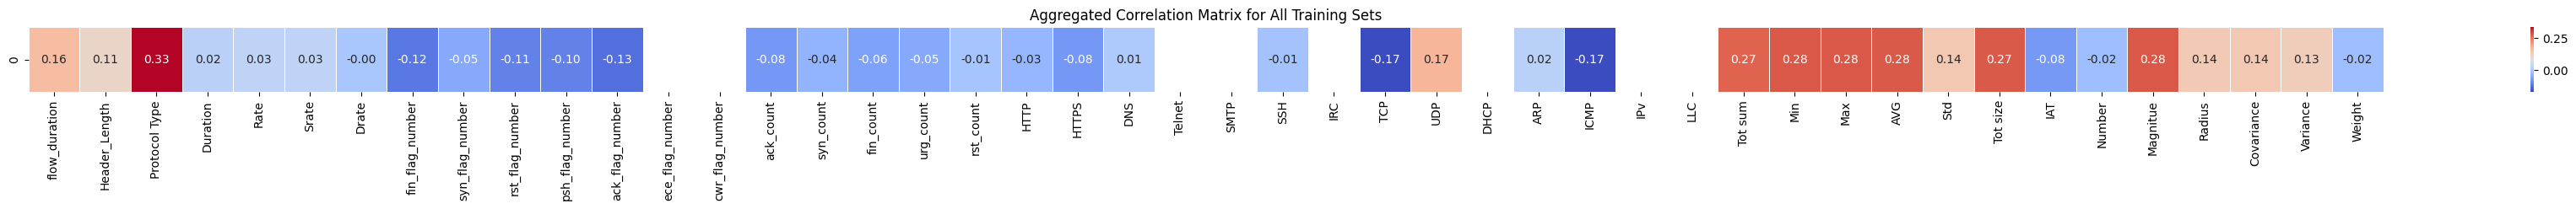

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(45,1))
sns.heatmap(correlation_matrices, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5,
            xticklabels=X_columns)
plt.title("Aggregated Correlation Matrix for All Training Sets")
plt.show()

In [11]:
from sklearn.metrics import confusion_matrix
import numpy as np
y_test = []
d_preds = {i:[] for i in range(len(DL_models))}
for test_set in tqdm(test_sets):
    d_test = pd.read_csv(DATASET_DIRECTORY + test_set)
    d_test[X_columns] = scaler.fit_transform(d_test[X_columns])
    new_y = [dict_7classes[k] for k in d_test[y_column]]
    d_test[y_column] = new_y
    y_test += list(d_test[y_column].values)
    for i in range(len(DL_models)):
        model = DL_models[i]
        y_preds = list(model.predict(d_test[X_columns]))
        d_preds[i] = d_preds[i] + y_preds
    del y_preds
    del d_test
    del new_y

  0%|          | 0/56 [00:00<?, ?it/s]

14110/14110 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


  2%|▏         | 1/56 [00:33<30:28, 33.25s/it]

7497/7497 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


  4%|▎         | 2/56 [00:50<21:42, 24.12s/it]

6840/6840 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


  5%|▌         | 3/56 [01:07<18:13, 20.63s/it]

7650/7650 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


W0000 00:00:1711469940.006275      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
  7%|▋         | 4/56 [01:25<17:07, 19.76s/it]

7609/7609 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


W0000 00:00:1711469957.960638      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
  9%|▉         | 5/56 [01:43<16:12, 19.07s/it]

6871/6871 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 11%|█         | 6/56 [02:00<15:08, 18.17s/it]

7497/7497 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 12%|█▎        | 7/56 [02:16<14:20, 17.56s/it]

7350/7350 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 14%|█▍        | 8/56 [02:34<14:13, 17.77s/it]

7706/7706 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 16%|█▌        | 9/56 [02:52<14:02, 17.93s/it]

7757/7757 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 18%|█▊        | 10/56 [03:11<13:54, 18.14s/it]

8018/8018 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


W0000 00:00:1711470064.504713      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
 20%|█▉        | 11/56 [03:30<13:48, 18.42s/it]

7772/7772 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 21%|██▏       | 12/56 [03:49<13:32, 18.46s/it]

14021/14021 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


 23%|██▎       | 13/56 [04:22<16:25, 22.92s/it]

7332/7332 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


W0000 00:00:1711470134.513170      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
 25%|██▌       | 14/56 [04:40<14:57, 21.38s/it]

13992/13992 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


 27%|██▋       | 15/56 [05:13<17:04, 24.98s/it]

7490/7490 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


W0000 00:00:1711470185.611804      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
 29%|██▊       | 16/56 [05:31<15:14, 22.86s/it]

7177/7177 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 30%|███       | 17/56 [05:48<13:48, 21.23s/it]

8030/8030 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 32%|███▏      | 18/56 [06:08<13:03, 20.61s/it]

13930/13930 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


 34%|███▍      | 19/56 [06:41<15:10, 24.61s/it]

7472/7472 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 36%|███▌      | 20/56 [07:00<13:35, 22.65s/it]

7495/7495 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 38%|███▊      | 21/56 [07:17<12:21, 21.18s/it]

7615/7615 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 39%|███▉      | 22/56 [07:36<11:34, 20.43s/it]

7476/7476 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 41%|████      | 23/56 [07:54<10:48, 19.64s/it]

13897/13897 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


 43%|████▎     | 24/56 [08:27<12:43, 23.85s/it]

8015/8015 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


 45%|████▍     | 25/56 [08:52<12:26, 24.07s/it]

13964/13964 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


 46%|████▋     | 26/56 [09:26<13:35, 27.19s/it]

7567/7567 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 48%|████▊     | 27/56 [09:45<11:52, 24.58s/it]

14038/14038 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


W0000 00:00:1711470469.357243      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
 50%|█████     | 28/56 [10:19<12:48, 27.45s/it]

7000/7000 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 52%|█████▏    | 29/56 [10:36<10:57, 24.35s/it]

8147/8147 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


 54%|█████▎    | 30/56 [10:56<09:58, 23.02s/it]

7476/7476 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 55%|█████▌    | 31/56 [11:13<08:47, 21.11s/it]

7652/7652 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 57%|█████▋    | 32/56 [11:32<08:11, 20.49s/it]

13836/13836 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


 59%|█████▉    | 33/56 [12:06<09:22, 24.47s/it]

7099/7099 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 61%|██████    | 34/56 [12:23<08:14, 22.49s/it]

7434/7434 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 62%|██████▎   | 35/56 [12:42<07:26, 21.27s/it]

7345/7345 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 64%|██████▍   | 36/56 [13:01<06:50, 20.51s/it]

13935/13935 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


 66%|██████▌   | 37/56 [13:35<07:47, 24.62s/it]

7256/7256 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 68%|██████▊   | 38/56 [13:53<06:48, 22.68s/it]

7176/7176 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 70%|██████▉   | 39/56 [14:11<06:01, 21.24s/it]

13961/13961 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


 71%|███████▏  | 40/56 [14:45<06:43, 25.23s/it]

13594/13594 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


 73%|███████▎  | 41/56 [15:19<06:56, 27.74s/it]

7257/7257 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 75%|███████▌  | 42/56 [15:37<05:49, 24.96s/it]

7183/7183 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 77%|███████▋  | 43/56 [15:55<04:56, 22.80s/it]

8014/8014 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 79%|███████▊  | 44/56 [16:15<04:22, 21.89s/it]

7498/7498 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 80%|████████  | 45/56 [16:34<03:51, 21.04s/it]

7203/7203 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 82%|████████▏ | 46/56 [16:52<03:21, 20.11s/it]

7229/7229 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 84%|████████▍ | 47/56 [17:10<02:55, 19.50s/it]

7229/7229 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 86%|████████▌ | 48/56 [17:27<02:29, 18.63s/it]

7265/7265 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 88%|████████▊ | 49/56 [17:45<02:09, 18.53s/it]

13738/13738 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


 89%|████████▉ | 50/56 [18:19<02:19, 23.17s/it]

7300/7300 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


W0000 00:00:1711470972.277636      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
 91%|█████████ | 51/56 [18:38<01:49, 21.91s/it]

13989/13989 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


 93%|█████████▎| 52/56 [19:13<01:43, 25.78s/it]

13889/13889 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


 95%|█████████▍| 53/56 [19:48<01:25, 28.50s/it]

14032/14032 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


 96%|█████████▋| 54/56 [20:23<01:00, 30.50s/it]

7116/7116 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 98%|█████████▊| 55/56 [20:40<00:26, 26.66s/it]

7336/7336 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


100%|██████████| 56/56 [20:59<00:00, 22.50s/it]



Confusion Matrix:



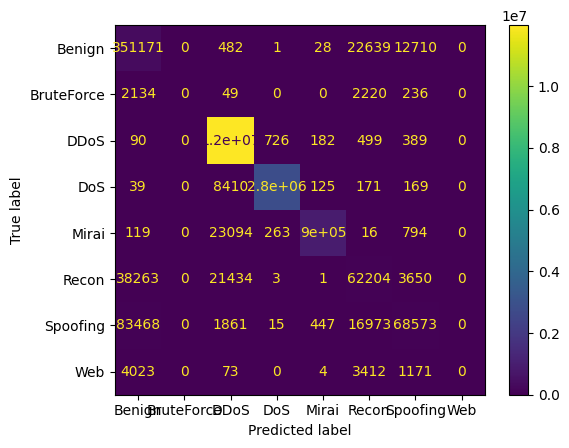

CNN
              precision    recall  f1-score   support

      Benign       0.73      0.91      0.81    387031
  BruteForce       0.00      0.00      0.00      4639
        DDoS       1.00      1.00      1.00  11981259
         DoS       1.00      1.00      1.00   2851474
       Mirai       1.00      0.97      0.99    929281
       Recon       0.58      0.50      0.53    125555
    Spoofing       0.78      0.40      0.53    171337
         Web       0.00      0.00      0.00      8683

    accuracy                           0.98  16459259
   macro avg       0.64      0.60      0.61  16459259
weighted avg       0.98      0.98      0.98  16459259

accuracy_score:  0.9847877112815346
recall_score:  0.6355077362605022
precision_score:  0.596697932247575
f1_score:  0.606842339996746


In [12]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
for k, v in d_preds.items():
    if isinstance(v, list):
        v = np.array(v)
    y_preds = np.argmax(v, axis=1)
    label_encoder.fit(original_labels)
    y_preds = label_encoder.inverse_transform(y_preds)
    from sklearn.metrics import ConfusionMatrixDisplay
    print(f"\nConfusion Matrix:\n")
    ConfusionMatrixDisplay.from_predictions(y_test, y_preds)
    plt.show()
    from sklearn.metrics import classification_report
    
    print(f"{DL_names[k]}")
    print(classification_report(y_test,y_preds))
    print('accuracy_score: ', accuracy_score(y_preds, y_test))
    print('recall_score: ', recall_score(y_preds, y_test, average='macro'))
    print('precision_score: ', precision_score(y_preds, y_test, average='macro'))
    print('f1_score: ', f1_score(y_preds, y_test, average='macro'))